In [1]:
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch3d
from tensorboardX import SummaryWriter

from co3d.dataset.dataset_zoo import dataset_zoo
from co3d.dataset.dataloader_zoo import dataloader_zoo

from network.model import NerFormer
from network.feature_network import FeatureNet

from positional_embedding import HarmonicEmbedding
from ray_sampling import RaySampler
from rendering import render_rays, render_image

In [2]:
import config

args = config.get_args()

In [3]:
args.exp_name = "1208_1207_exp_+inv_depth_True"

args

{'root_dir': './',
 'exp_name': '1208_1207_exp_+inv_depth_True',
 'N_rays': 800,
 'N_src': 3,
 'lr': 0.0005,
 'n_iters': 100000,
 'pe_dim': 10,
 'chunk_size': 3200,
 'N_samples': 32,
 'N_importance': 16,
 'inv_uniform': True,
 'det': True,
 'render_stride': 1,
 'ray_sampling_mode': 'uniform',
 'center_ratio': 0.8,
 'log_img': 2000,
 'log_loss': 100,
 'log_weight': 5000}

In [4]:
torch.cuda.empty_cache()

!nvidia-smi

Wed Dec  8 13:42:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:60:00.0 Off |                  N/A |
| 27%   27C    P8     5W / 250W |      0MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
def data_to_frame(co3d_data, device, tgt_idx, src_idxs):
    imgs = co3d_data.image_rgb.to(device)
    img_paths = co3d_data.image_path
    masks = co3d_data.fg_probability.to(device)
    camera = co3d_data.camera.to(device)

    target = {}
    target["rgb"] = imgs[tgt_idx]
    target["rgb_path"] = img_paths[tgt_idx]
    target["mask"] = masks[tgt_idx]
    target["camera"] = camera
    # 현재 타겟 카메라의 위치를 기준으로
    # 샘플링할 ray들의 depth range 계산
    target_camera_position = camera.get_camera_center()[tgt_idx]
    near = torch.norm(target_camera_position) - 8
    far = torch.norm(target_camera_position) + 8
    depth_range =  torch.tensor([near, far], dtype=torch.float32)
    target["depth_range"] = depth_range

    srcs = {}
    srcs["rgb"] = imgs[src_idxs]
    srcs["mask"] = masks[src_idxs]

    return target, srcs

In [5]:
def log_view_to_tensorboard(args, writer, global_step, model, ray_sampler, feature_maps, srcs, src_idxs, gt_img, gt_mask, prefix=''):
    model.eval()

    with torch.no_grad():
        # 이미지의 모든 픽셀에 대해 정의된 ray batch 생성.
        ray_batch = ray_sampler.get_all()

        output = render_image(ray_sampler=ray_sampler,
                            ray_batch=ray_batch,
                            src_idxs=src_idxs,
                            model=model,
                            feature_maps=feature_maps,
                            args=args,
                            )

    srcs = srcs["rgb"].detach().cpu()
    N_src = srcs.shape[0]

    if args.render_stride != 1:
        gt_img = gt_img[::args.render_stride, ::args.render_stride]
        srcs = srcs[:, :, ::args.render_stride, ::args.render_stride]

    img_HWC2CHW = lambda x: x.permute(2, 0, 1)
    
    rgb_gt = img_HWC2CHW(gt_img)
    rgb_pred = img_HWC2CHW(output['outputs_coarse']['rgb'].detach().cpu())

    h = rgb_gt.shape[-2]
    w = rgb_gt.shape[-1]

    srcs_im = torch.zeros(3, h, N_src*w)
    for i in range(0, N_src):
        srcs_im[:, :h, i*w:(i+1)*w] = srcs[i]

    rgb_im = torch.zeros(3, h, 3*w)
    rgb_im[:, :rgb_gt.shape[-2], :rgb_gt.shape[-1]] = rgb_gt
    rgb_im[:, :rgb_pred.shape[-2], w:w+rgb_pred.shape[-1]] = rgb_pred

    # depth_im = output['outputs_coarse']['depth'].detach().cpu()
    # acc_map = torch.sum(output['outputs_coarse']['weights'], dim=-1).detach().cpu()
    mask_gt = img_HWC2CHW(gt_mask).detach().cpu()
    mask_pred = img_HWC2CHW(output["outputs_coarse"]["mask"].detach().cpu().unsqueeze(-1))

    if output['outputs_fine'] is None:
        # depth_im = img_HWC2CHW(colorize(depth_im, cmap_name='jet', append_cbar=True))
        # depth_im = img_HWC2CHW(depth_im)
        # acc_map = img_HWC2CHW(colorize(acc_map, range=(0., 1.), cmap_name='jet', append_cbar=False))
        mask_im = torch.cat((mask_gt, mask_pred), dim=-1)
    else:
        rgb_fine = img_HWC2CHW(output['outputs_fine']['rgb'].detach().cpu())
        rgb_im[:, :rgb_fine.shape[-2], 2*w:2*w+rgb_fine.shape[-1]] = rgb_fine
        # depth_im = torch.cat((depth_im, output['outputs_fine']['depth'].detach().cpu()), dim=-1)
        # depth_im = img_HWC2CHW(colorize(depth_im, cmap_name='jet', append_cbar=True))
        # depth_im = img_HWC2CHW(depth_im)
        # acc_map = torch.cat((acc_map, torch.sum(output['outputs_fine']['weights'], dim=-1).detach().cpu()), dim=-1)
        # acc_map = img_HWC2CHW(colorize(acc_map, range=(0., 1.), cmap_name='jet', append_cbar=False))
        mask_fine = img_HWC2CHW(output["outputs_fine"]["mask"].detach().cpu().unsqueeze(-1))
        mask_im = torch.cat((mask_gt, mask_pred, mask_fine), dim=-1)

    # 위에서 만든 시각화 이미지를 텐서보드에 기록
    writer.add_image(prefix + 'rgb_sources', srcs_im, global_step)
    writer.add_image(prefix + 'rgb_gt-coarse-fine', rgb_im, global_step)
    # writer.add_image(prefix + 'depth_gt-coarse-fine', depth_im, global_step)
    # writer.add_image(prefix + 'acc-coarse-fine', acc_map, global_step)
    writer.add_image(prefix + 'mask_gt-coarse-fine', mask_im, global_step)

    # write scalar
    # pred_rgb = output['outputs_fine']['rgb'] if output['outputs_fine'] is not None else output['outputs_coarse']['rgb']
    # psnr_curr_img = img2psnr(pred_rgb.detach().cpu(), gt_img)
    # writer.add_scalar(prefix + 'psnr_image', psnr_curr_img, global_step)

    model.train()

save directory 경로 설정 및 생성

In [6]:
device = "cuda:0"

out_folder = os.path.join(args.root_dir, 'out', args.exp_name)
print('outputs will be saved to {}'.format(out_folder))
os.makedirs(out_folder, exist_ok=True)

outputs will be saved to ./out/1208_1207_exp_+inv_depth_True


In [9]:
# # save the args and config files
# f = os.path.join(out_folder, 'args.txt')
# with open(f, 'w') as file:
#     for arg in sorted(vars(args)):
#         attr = getattr(args, arg)
#         file.write('{} = {}\n'.format(arg, attr))

# if args.config is not None:
#     f = os.path.join(out_folder, 'config.txt')
#     if not os.path.isfile(f):
#         shutil.copy(args.config, f)

dataset, dataloader 생성

In [7]:
category = "teddybear"
task = "singlesequence"
single_sequence_id = 0

datasets = dataset_zoo(
        category=category,
        assert_single_seq=task == "singlesequence",
        dataset_name=f"co3d_{task}",
        test_on_train=False,
        load_point_clouds=False,
        test_restrict_sequence_id=single_sequence_id,
    )

set_names_mapping :{'train': ['test_known'], 'val': ['test_known', 'test_unseen'], 'test': ['test_known', 'test_unseen']}
Dataset :  train
subsets :  ['test_known']
Loading Co3D frames from ../dataset/CO3D/teddybear/frame_annotations.jgz.
Loading Co3D sequences from ../dataset/CO3D/teddybear/sequence_annotations.jgz.
Loading Co3D subset lists from ../dataset/CO3D/teddybear/set_lists.json.
Removing images with empty masks.
... filtered 72865 -> 63135
Limitting Co3D dataset to the '['test_known']' subsets.
pick_sequence: ['34_1479_4753']
... filtered 75 -> 1
CO3D Dataset #frames=81
Dataset :  val
subsets :  ['test_known', 'test_unseen']
Loading Co3D frames from ../dataset/CO3D/teddybear/frame_annotations.jgz.
Loading Co3D sequences from ../dataset/CO3D/teddybear/sequence_annotations.jgz.
Loading Co3D subset lists from ../dataset/CO3D/teddybear/set_lists.json.
Removing images with empty masks.
... filtered 72865 -> 63135
Limitting Co3D dataset to the '['test_known', 'test_unseen']' subset

In [50]:
print(datasets["train"].__len__())
print(datasets["val"].__len__())
print(datasets["test"].__len__())


81
102
102


In [51]:
datasets["train"]

Co3dDataset(frame_annotations_file='../dataset/CO3D/teddybear/frame_annotations.jgz', sequence_annotations_file='../dataset/CO3D/teddybear/sequence_annotations.jgz', subset_lists_file='../dataset/CO3D/teddybear/set_lists.json', subsets=['test_known'], limit_to=-1, limit_sequences_to=-1, pick_sequence=['34_1479_4753'], exclude_sequence=[], limit_category_to=[], dataset_root='../dataset/CO3D', load_images=True, load_depths=True, load_depth_masks=True, load_masks=True, load_point_clouds=False, max_points=0, mask_images=False, mask_depths=False, image_height=800, image_width=800, box_crop=True, box_crop_mask_thr=0.4, box_crop_context=0.3, remove_empty_masks=True, n_frames_per_sequence=-1, seed=0, eval_batches=None)

In [8]:
dataloaders = dataloader_zoo(
        datasets,
        dataset_name=f"co3d_{task}",
        batch_size=(args.N_src + 1),
        # num_workers=2,
        dataset_len=1000,
        dataset_len_val=10,
        images_per_seq_options=[100],
    )

train_loader = dataloaders["train"]
val_loader = dataloaders["val"]
test_loader = dataloaders["test"]

dataset_set : train, dataset : CO3D Dataset #frames=81, batch_size : 4, dataset_len : 1000, dataset_len_val : 10, images_per_seq_options : [100]
dataset_set : val, dataset : CO3D Dataset #frames=102, batch_size : 4, dataset_len : 1000, dataset_len_val : 10, images_per_seq_options : [100]
dataset_set : test, dataset : CO3D Dataset #frames=102, batch_size : 4, dataset_len : 1000, dataset_len_val : 10, images_per_seq_options : [100]


In [53]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

1000
10
100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


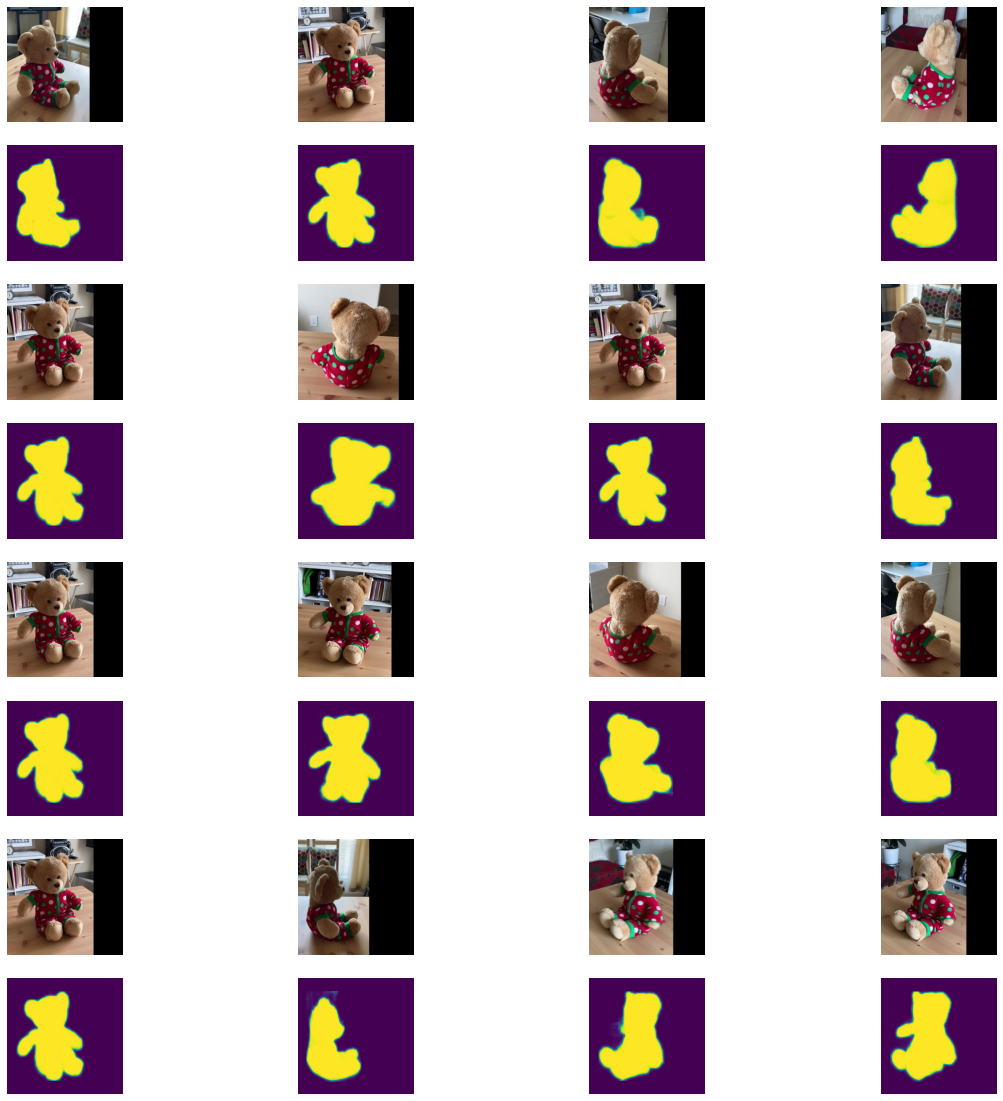

In [54]:
plt.figure(figsize=(20, 20))

for idx, data in enumerate(train_loader):
    imgs = data.image_rgb
    masks = data.fg_probability
    
    for i, (img, mask) in enumerate(zip(imgs, masks)):
        plt.subplot(8, 4, 8*idx + (i + 1))
        img = img.numpy().transpose(1, 2, 0)
        plt.imshow(img)
        plt.axis("off")

        plt.subplot(8, 4, 8*idx + (i + 1) + 4)
        mask = mask.numpy().transpose(1, 2, 0)
        plt.imshow(mask)
        plt.axis("off")

    if idx == 3:
        break

## Model 객체 생성

In [9]:
resnet_feature_dim = 32 * 3
rgb_dim = 3
segemtation_dim = 1
pe_dim = args.pe_dim

d_z = resnet_feature_dim + rgb_dim + segemtation_dim + pe_dim*2*3
print(f"D_z: {d_z}")

D_z: 160


In [10]:
net = NerFormer(d_z=d_z).to(device)

In [11]:
feature_net = FeatureNet().to(device)

In [58]:
!nvidia-smi

Mon Dec  6 12:14:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:60:00.0 Off |                  N/A |
| 27%   31C    P2    52W / 250W |   7254MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Criterion

In [12]:
mse_loss = nn.MSELoss(reduction="sum")         # target RGB <-> GT RGB
bce_loss = nn.BCELoss(reduction="sum")         # target Mask <-> GT Mask

tb_dir = os.path.join(args.root_dir, 'logs/', args.exp_name)
writer = SummaryWriter(tb_dir)
print('saving tensorboard files to {}'.format(tb_dir))

scalars_to_log = {}

saving tensorboard files to ./logs/1208_1207_exp_+inv_depth_True


In [13]:
n_iters = args.n_iters
global_step = 0
epoch = 0

In [14]:
optimizer = torch.optim.Adam(net.parameters(), lr=args.lr)

In [15]:
target_idx = 0
sources = [src_idx for src_idx in range(1, args.N_src + 1)]

PE = HarmonicEmbedding(n_harmonic_functions=pe_dim).to(device)
args["PE"] = PE

while global_step < n_iters + 1:
    for train_data in train_loader:
        time0 = time.time()
        
        ##################### target, source data frame 구성 #####################
        target, srcs = data_to_frame(train_data, device, target_idx, sources)

        ######################## source feature map 구성 ########################
        with torch.no_grad():
            feature_maps = feature_net(srcs["rgb"], srcs["mask"])

        # ray sampler 생성
        ray_sampler = RaySampler(target, target_idx, device, args)
        # 타겟 이미지에서 N_rays개의 ray 샘플링
        ray_batch = ray_sampler.random_sample(args.N_rays, args.ray_sampling_mode)

        output = render_rays(ray_batch, net, net, feature_maps, sources, args)

        optimizer.zero_grad()

        coarse_rgb_loss = mse_loss(output["outputs_coarse"]["rgb"], ray_batch["rgb"])
        # coarse_mask_loss = bce_loss(output["outputs_coarse"]["mask"][..., 0], ray_batch["mask"])

        coarse_loss = coarse_rgb_loss # + coarse_mask_loss

        fine_rgb_loss = mse_loss(output["outputs_fine"]["rgb"], ray_batch["rgb"])
        # fine_mask_loss = bce_loss(output["outputs_fine"]["mask"][..., 0], ray_batch["mask"])

        fine_loss = fine_rgb_loss # + fine_mask_loss

        total_loss = coarse_loss + fine_loss
        total_loss.backward()

        scalars_to_log['loss'] = total_loss.item()
        
        optimizer.step()

        dt = time.time() - time0

        # loss 출력
        if global_step % args.log_loss == 0 or global_step < 10:
            scalars_to_log['train/coarse-rgb-loss'] = coarse_rgb_loss
            # scalars_to_log['train/coarse-mask-loss'] = coarse_mask_loss

            if output['outputs_fine'] is not None:
                scalars_to_log['train/fine-rgb-loss'] = fine_rgb_loss
                # scalars_to_log['train/fine_mask_loss'] = fine_mask_loss

            logstr = '{} Epoch: {}  step: {} '.format(args.exp_name, epoch, global_step)
            for k in scalars_to_log.keys():
                logstr += ' {}: {:.6f}'.format(k, scalars_to_log[k])
                writer.add_scalar(k, scalars_to_log[k], global_step)
            print(logstr)
            print('each iter time {:.05f} seconds'.format(dt))

        # checkpoint 저장
        if global_step % args.log_weight == 0:
            print(f"Step[{global_step+1}/{n_iters}]: Checkpoint 저장...")
            save_path = os.path.join(out_folder, "model_{:06d}.pth".format(global_step))

            to_save = {
                        'optimizer': optimizer.state_dict(),
                        'net': net.state_dict(),
                        }
            torch.save(to_save, save_path)

        # validation 시각화 저장
        if global_step % args.log_img == 0:
            ######################## current training data ########################
            print(f"Step[{global_step+1}/{n_iters}]: Training data 결과 저장...")

            # train ray sampler 생성
            train_ray_sampler = RaySampler(target, target_idx, device, args)
            H, W = train_ray_sampler.H, train_ray_sampler.W
            train_gt_img = train_ray_sampler.rgb.reshape(H, W, 3)
            train_gt_mask = train_ray_sampler.mask.reshape(H, W, 1)
            # # log
            log_view_to_tensorboard(args, writer, global_step, net, train_ray_sampler, feature_maps,
                                   srcs, sources, train_gt_img, train_gt_mask, prefix='train/')

            ######################## random validation data ########################
            print(f"Step[{global_step+1}/{n_iters}]: Validation data 결과 저장...")

            val_data = next(iter(val_loader))
            #  validation target, source data frame 구성 
            val_target, val_srcs = data_to_frame(val_data, device, target_idx, sources)

            with torch.no_grad():
                val_feature_maps = feature_net(val_srcs["rgb"], val_srcs["mask"])

            # validation ray sampler 생성
            val_ray_sampler = RaySampler(val_target, target_idx, device, args)
            H, W = val_ray_sampler.H, val_ray_sampler.W
            val_gt_img = val_ray_sampler.rgb.reshape(H, W, 3)
            val_gt_mask = train_ray_sampler.mask.reshape(H, W, 1)
            # log
            log_view_to_tensorboard(args, writer, global_step, net, val_ray_sampler, val_feature_maps,
                                   val_srcs, sources, val_gt_img, val_gt_mask, prefix='val/')

        global_step += 1

        if global_step > n_iters + 1:
            break
        
    epoch += 1

1208_1207_exp_+inv_depth_True Epoch: 0  step: 0  loss: 675.316467 train/coarse-rgb-loss: 337.913269 train/fine-rgb-loss: 337.403198
each iter time 1.26923 seconds
Step[1/100000]: Checkpoint 저장...
Step[1/100000]: Training data 결과 저장...
Step[1/100000]: Validation data 결과 저장...
1208_1207_exp_+inv_depth_True Epoch: 0  step: 1  loss: 581.609985 train/coarse-rgb-loss: 290.737030 train/fine-rgb-loss: 290.872925
each iter time 0.33313 seconds
1208_1207_exp_+inv_depth_True Epoch: 0  step: 2  loss: 675.686951 train/coarse-rgb-loss: 337.608459 train/fine-rgb-loss: 338.078491
each iter time 0.30069 seconds
1208_1207_exp_+inv_depth_True Epoch: 0  step: 3  loss: 747.201172 train/coarse-rgb-loss: 373.522430 train/fine-rgb-loss: 373.678711
each iter time 0.29833 seconds
1208_1207_exp_+inv_depth_True Epoch: 0  step: 4  loss: 664.503174 train/coarse-rgb-loss: 332.095459 train/fine-rgb-loss: 332.407715
each iter time 0.31009 seconds
1208_1207_exp_+inv_depth_True Epoch: 0  step: 5  loss: 512.578857 train/

In [78]:
bce_loss(torch.tensor([0.9]), torch.tensor([1.]))

tensor(0.1054)

In [133]:
from point_sampling import sample_along_camera_ray

In [145]:
args.inv_uniform

True

In [152]:
pts, z_vals_inv_true = sample_along_camera_ray(ray_batch["ray_o"], ray_batch["ray_d"], ray_batch["depth_range"],
                                            32,
                                            inv_uniform=True,
                                            det=args.det)

pts, z_vals_inv_false = sample_along_camera_ray(ray_batch["ray_o"], ray_batch["ray_d"], ray_batch["depth_range"],
                                            32,
                                            inv_uniform=False,
                                            det=args.det)

In [153]:
print(z_vals_inv_true[0])
print(z_vals_inv_false[0])

tensor([ 1.2470,  1.2855,  1.3264,  1.3700,  1.4166,  1.4664,  1.5199,  1.5774,
         1.6395,  1.7067,  1.7795,  1.8589,  1.9457,  2.0410,  2.1461,  2.2627,
         2.3926,  2.5384,  2.7030,  2.8905,  3.1060,  3.3561,  3.6501,  4.0005,
         4.4254,  4.9512,  5.6188,  6.4946,  7.6937,  9.4360, 12.1982, 17.2470],
       device='cuda:0')
tensor([ 1.2470,  1.7631,  2.2793,  2.7954,  3.3115,  3.8276,  4.3438,  4.8599,
         5.3760,  5.8922,  6.4083,  6.9244,  7.4405,  7.9567,  8.4728,  8.9889,
         9.5051, 10.0212, 10.5373, 11.0534, 11.5696, 12.0857, 12.6018, 13.1180,
        13.6341, 14.1502, 14.6664, 15.1825, 15.6986, 16.2147, 16.7309, 17.2470],
       device='cuda:0')


In [154]:
delta_inv_true = z_vals_inv_true[..., 1:] - z_vals_inv_true[..., :-1]
delta_inv_true = torch.cat((delta_inv_true, delta_inv_true[..., -1:]), dim=-1)
print(delta_inv_true[0])

delta_inv_false = z_vals_inv_false[..., 1:] - z_vals_inv_false[..., :-1]
delta_inv_false = torch.cat((delta_inv_false, delta_inv_false[..., -1:]), dim=-1)
print(delta_inv_false[0])

tensor([0.0385, 0.0409, 0.0436, 0.0466, 0.0499, 0.0535, 0.0575, 0.0621, 0.0671,
        0.0729, 0.0794, 0.0868, 0.0953, 0.1051, 0.1165, 0.1299, 0.1457, 0.1647,
        0.1875, 0.2155, 0.2502, 0.2940, 0.3504, 0.4249, 0.5258, 0.6676, 0.8757,
        1.1991, 1.7422, 2.7622, 5.0488, 5.0488], device='cuda:0')
tensor([0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161,
        0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161,
        0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161,
        0.5161, 0.5161, 0.5161, 0.5161, 0.5161], device='cuda:0')


In [165]:
from rendering import feature_sampling

In [170]:
positional_embedding = args.PE(pts)
input_tensor = feature_sampling(feature_maps, ray_batch["camera"], pts, positional_embedding, (H, W), [1, 2, 3])
coarse_densities, coarse_colors = net(input_tensor)

In [197]:
print(coarse_colors.min(), coarse_colors.max())
colors_clamp = torch.clamp(coarse_colors, min=0., max=1.)
print(colors_clamp.min(), colors_clamp.max())

tensor(-0.4099, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.5011, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)


In [21]:
output["outputs_fine"]["mask"][..., 0]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [91]:
bce_loss_sum = nn.BCELoss(reduction="sum")

In [108]:
x = torch.tensor([0.001])
y = torch.tensor([1])

print(y*torch.log(x) + (1-y)*torch.log(1-torch.log(x)))

tensor([-6.9078])


In [128]:
bce_loss_sum(output["outputs_fine"]["mask"][0, 0], ray_batch["mask"][0])

tensor(100., device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

In [ ]:
bce_loss_sum(output["outputs_fine"]["mask"][, 0], ray_batch["mask"][0])

In [79]:
bce_loss.reduction

'mean'

In [70]:
print(coarse_mask_loss)
print(fine_mask_loss)

tensor(4.3101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(71.9328, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


In [68]:
bce_loss(output["outputs_coarse"]["mask"][..., 0], ray_batch["mask"])

tensor(4.3101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

In [32]:
torch.cuda.empty_cache()

In [22]:
train_ray_sampler.rgb.shape

torch.Size([640000, 3])

In [26]:
print(train_ray_sampler.mask.shape)

print(train_ray_sampler.mask.reshape(H, W, 1).shape)

torch.Size([640000])
torch.Size([800, 800, 1])


In [19]:
output["outputs_coarse"].keys()

dict_keys(['rgb', 'weights', 'alphas', 'mask'])

In [20]:
output["outputs_coarse"]["rgb"].shape

torch.Size([800, 3])